In [1]:
# import libraries
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image
from sklearn.metrics import mean_squared_error

# set file path
file_path = 'bnw.png'  # update to your file location

# set range for n values
n_values = range(1, 17)

In [3]:
# function to convert 2D coordinates to 1D Hilbert index
def xy2d(n, x, y):
    d = 0
    s = n // 2
    while s > 0:
        rx = (x & s) > 0
        ry = (y & s) > 0
        d += s * s * ((3 * rx) ^ ry)
        x, y = rot(s, x, y, rx, ry)
        s //= 2
    return d

# rotation function for Hilbert calculation
def rot(n, x, y, rx, ry):
    if ry == 0:
        if rx == 1:
            x = n-1 - x
            y = n-1 - y
        x, y = y, x
    return x, y

In [4]:
def d2xy(n, d):
    x = y = 0
    s = 1
    t = d
    while s < n:
        rx = 1 & (t // 2)
        ry = 1 & (t ^ rx)
        x, y = rot(s, x, y, rx, ry)
        x += s * rx
        y += s * ry
        t //= 4
        s *= 2
    #print(x,y)
    return x, y

In [3]:
# test fidelity for different values of n and print mse
mse_values = []
for exp_n in n_values:
    n = 2 ** exp_n
    # calculate hilbert indices
    coords = [(x, y) for y in range(image_array.shape[0]) for x in range(image_array.shape[1])]
    indices = np.array([xy2d(n, x, y) for x, y in coords])

    # reconstruct image from indices
    reconstructed_image = np.zeros_like(image_array)
    for index, h_index in enumerate(indices):
        x, y = coords[index]
        reconstructed_x, reconstructed_y = d2xy(n, h_index)
        if 0 <= reconstructed_x < image_array.shape[1] and 0 <= reconstructed_y < image_array.shape[0]:
            reconstructed_image[reconstructed_y, reconstructed_x] = image_array[y, x]

    # compute mse
    mse = mean_squared_error(image_array.flatten(), reconstructed_image.flatten())
    mse_values.append(mse)
    print(f"n: 2^{exp_n}, MSE: {mse}")

NameError: name 'xy2d' is not defined

In [6]:
## create new image array for reconstruction
reconstructed_image_array = np.zeros_like(image_array)

# reconstruct image from Hilbert indices
for index, (x, y) in enumerate(coords):
    reconstructed_x, reconstructed_y = d2xy(n, indices[index])
    if 0 <= reconstructed_x < width and 0 <= reconstructed_y < height:
        reconstructed_image_array[reconstructed_y, reconstructed_x] = image_array[y, x]


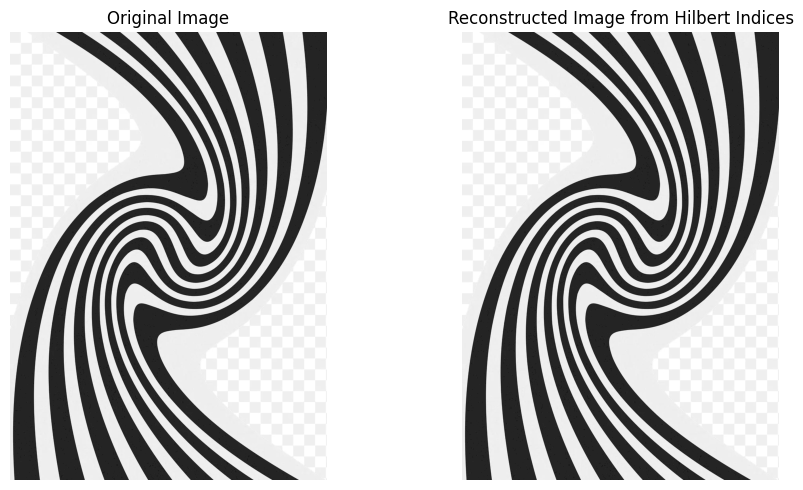

In [7]:
# visualize original and reconstructed images
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 5))
ax1.imshow(image_array, cmap='gray')
ax1.set_title('Original Image')
ax1.axis('off')

ax2.imshow(reconstructed_image_array, cmap='gray')
ax2.set_title('Reconstructed Image from Hilbert Indices')
ax2.axis('off')

plt.tight_layout()
plt.show()

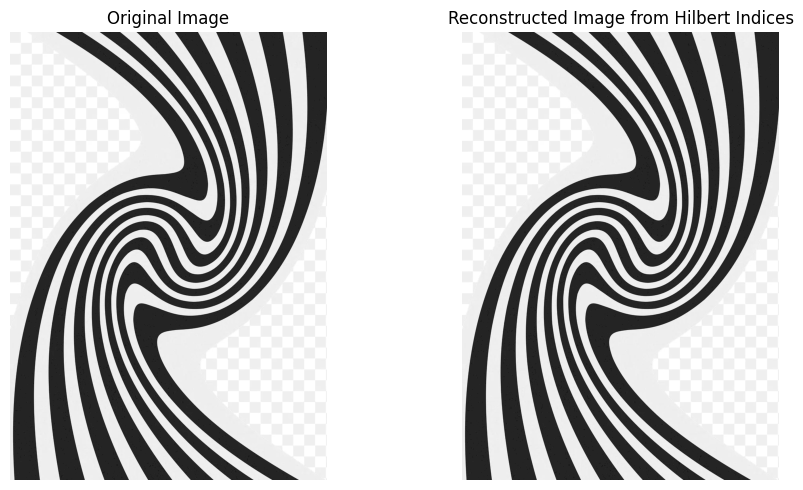

In [8]:
# Create a figure with two subplots
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 5))

# Show original image
ax1.imshow(image_array, cmap='gray')
ax1.set_title('Original Image')
ax1.axis('off')

# Show reconstructed image
ax2.imshow(reconstructed_image_array, cmap='gray')
ax2.set_title('Reconstructed Image from Hilbert Indices')
ax2.axis('off')

# Display the plots
plt.tight_layout()
plt.show()

In [9]:
def plot_hilbert_vs_price_binary(data, indices, price_column='price', binary_column='hotwaterheating', figsize=(10, 6), xlabel='Hilbert Index', ylabel='Price', title='Hilbert Index vs. Price', color_map=None):
    """
    Plots Hilbert indices against property prices and colors points based on a binary column.

    Parameters:
    - data: DataFrame containing the property data.
    - indices: Array of Hilbert indices corresponding to properties in `data`.
    - price_column: String, the name of the column in `data` that contains property prices.
    - binary_column: String, the name of the binary column to color the points by.
    - figsize: Tuple, the size of the figure.
    - xlabel: String, label for the x-axis.
    - ylabel: String, label for the y-axis.
    - title: String, title of the plot.
    - color_map: Dictionary, mapping binary values to colors.
    """
    plt.figure(figsize=figsize)
    
    # Check if color_map is provided, otherwise use default colors
    if color_map is None:
        color_map = {'yes': 'cyan', 'no': 'red'}

    # Extract colors from the binary_column using the color map
    if binary_column in data.columns:
        colors = data[binary_column].map(color_map)
    else:
        raise ValueError(f"Column {binary_column} does not exist in the DataFrame.")
    
    plt.scatter(indices, data[price_column], c=colors, alpha=0.5)
    plt.xlabel(xlabel)
    plt.ylabel(ylabel)
    plt.title(title)
    plt.grid(True)
    plt.show()

In [10]:
# Example call to the function with a binary column 'mainroad'
plot_hilbert_vs_price_binary(data, indices, price_column='price', binary_column='hotwaterheating', figsize=(12, 8), xlabel='Hilbert Index', ylabel='Price in $', title='Property Price Distribution along Hilbert Curve by Main Road Presence')

NameError: name 'data' is not defined

In [ ]:
# assuming `indices` is an array or list of Hilbert indices and `n` is defined as the size of the grid
for d in indices:
    x, y = d2xy(n, d)
    print(f"Hilbert index: {d} => (x, y): ({x}, {y})")

In [ ]:
# create a figure with two subplots
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(20, 10))

# plot original composite score vs area
ax1.scatter(data['normalized_area'], data['normalized_score'], color='blue', alpha=0.5)
ax1.set_title('Original Values: Area vs. Composite Score')
ax1.set_xlabel('Normalized Area')
ax1.set_ylabel('Normalized Composite Score')

# reconstruct x and y values from hilbert indices and plot them
reconstructed = np.array([d2xy(n, d) for d in indices])
ax2.scatter(reconstructed[:, 0] / n, reconstructed[:, 1] / n, color='red', alpha=0.5)
ax2.set_title('Reconstructed Values from Hilbert Indices')
ax2.set_xlabel('Reconstructed Area')
ax2.set_ylabel('Reconstructed Composite Score')

# display the plots
plt.tight_layout()
plt.show()